<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Build Vector Embeddings for Video via Python Notebook & OpenAI CLIP</h1>
    </div>
</div>

___
## Install libraries

In [5]:
!pip cache purge

Files removed: 0


In [6]:
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install matplotlib --quiet
!pip install opencv-python-headless --quiet
!pip install torch torchvision torchaudio --quiet

In [7]:
import clip
import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import torch

from io import BytesIO
from IPython.display import Image, display
from PIL import Image as PILImage
from tqdm import tqdm

___
## Video

### Save video

In [8]:
# URL to the file
file_url = "https://github.com/VeryFatBoy/clip-demo/raw/main/videos/1_what_makes_singlestore_unique.mp4"

# Extract file name from the URL
local_video_path = os.path.basename(file_url)

# Download the file if it doesn't already exist
if not os.path.exists(local_video_path):
    with open(local_video_path, 'wb') as file:
        file.write(requests.get(file_url).content)
    print("File downloaded successfully")
else:
    print("File already exists, skipping download")

File downloaded successfully


### Play video

In [9]:
video = widgets.Video.from_file(
    local_video_path,
    loop = False
)

display(video)

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp42mp41\x00\x015\xa6moov\x00\x00\x00lmvhd...', loop='Fa…

___
## Load the CLIP model

**TL;DR**<br>
Contrastive Language-Image Pretraining (CLIP) is a model by OpenAI that understands both images and text by associating them in a shared embedding space.

**Summary**<br>
CLIP is a model that unifies the understanding of images and text by learning to associate them in a shared embedding space through contrastive pretraining. By using this unified representation, CLIP can perform image classification, zero-shot image classification, and image-text retrieval.

Contrastive pretraining is where CLIP learns to represent images and text in a shared embedding space. During pretraining, CLIP is presented with pairs of images and textual descriptions and is trained to predict whether they belong together or not.

Vision Transformer (ViT) is a neural network architecture for computer vision tasks. It processes images as sequences of patches. With patch embedding, positional embedding, and transformer encoder layers, ViT extracts features for tasks like image classification and object detection.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device = device)

___
## Extract frames from a video at 1-second intervals

**TL;DR**<br>
Break down a video into its individual picture frames.

**Summary**<br>
Take a video file as input and pull out individual frames from it. Start by opening the video file and determining its frame rate and total duration. Then, calculate how many frames to extract based on the duration. Iterate through the video, grabbing frames at regular intervals according to the frame rate and add them to a list. Once all frames are extracted, close the video file and return the list of frames.

In [11]:
def extract_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_seconds = total_frames / frame_rate
    target_frame_count = int(total_seconds)
    target_frame_index = 0
    for i in range(target_frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        target_frame_index += int(frame_rate)
    cap.release()
    return frames

___
## Generate embeddings for each frame

**TL;DR**<br>
Summarise what's happening in a picture in a simpler form.

**Summary**<br>
Process an input frame to create a numerical representation of its content. Start by converting the frame into a tensor and preparing it for analysis using preprocessing. Then, use a pretrained neural network model to compute a condensed numerical embedding that captures the frame's visual features. Finally, convert this embedding into a NumPy array and return it.

In [12]:
def generate_embedding(frame):
    frame_tensor = preprocess(PILImage.fromarray(frame)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(frame_tensor).cpu().numpy()
    return embedding[0]

___
## Store embeddings and image data in a Pandas DataFrame

**TL;DR**<br>
Extract and summarise visual information from a video into a structured format for further analysis.

**Summary**<br>
Process a video file to extract frames and generate embeddings for each frame, while also storing the frame image. Start by extracting frames from the video. Then, iterate through each frame to generate an embedding and collect the frame number, embedding, and image in a list. After processing all frames, organise this data into a Pandas DataFrame with columns for the frame number, embedding data, and frame data. Finally, return the DataFrame containing all the extracted information.

In [13]:
def store_frame_embedding_and_image(video_path):
    frames = extract_frames(video_path)
    data = [
        (i+1, generate_embedding(frame), frame)
        for i, frame in enumerate(tqdm(
            frames,
            desc = "Processing frames",
            bar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]")
        )
    ]
    return pd.DataFrame(data, columns = ["frame_number", "embedding_data", "frame_data"])

In [14]:
df = store_frame_embedding_and_image(local_video_path)

Processing frames: 100%|██████████| 142/142 [00:30<00:00,  4.73it/s]


In [15]:
df.head()

,frame_number,embedding_data,frame_data
0,1,"[-0.008894026, -0.078329444, -0.13918127, -0.3...","[[[128, 0, 73], [128, 0, 73], [128, 0, 73], [1..."
1,2,"[0.2084663, -0.22196358, -0.27845085, -0.31248...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72], [1..."
2,3,"[-0.13772786, 0.111325555, 0.15730622, -0.0025...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72], [1..."
3,4,"[-0.12250218, 0.1272018, 0.22842842, 0.0186848...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72], [1..."
4,5,"[-0.040195517, 0.10754895, 0.03397023, 0.21529...","[[[108, 0, 63], [108, 0, 63], [108, 0, 63], [1..."


___
## Calculate lengths of embeddings and frames

**TL;DR**<br>
Examine the size characteristics of the data stored in the DataFrame.

**Summary**<br>
Two Pandas Series are created to calculate the lengths of the embedding data and frame data for each entry in the DataFrame. Find the minimum and maximum lengths among these calculated lengths.

In [16]:
embedding_lengths = df["embedding_data"].str.len()
frame_lengths = df["frame_data"].str.len()

# Calculate min and max lengths for embeddings and frames
min_embedding_length, max_embedding_length = embedding_lengths.min(), embedding_lengths.max()
min_frame_length, max_frame_length = frame_lengths.min(), frame_lengths.max()

# Print results
print(f"Min length of embedding vectors: {min_embedding_length}")
print(f"Max length of embedding vectors: {max_embedding_length}")
print(f"Min length of frame data vectors: {min_frame_length}")
print(f"Max length of frame data vectors: {max_frame_length}")

Min length of embedding vectors: 512
Max length of embedding vectors: 512
Min length of frame data vectors: 1080
Max length of frame data vectors: 1080


In [17]:
# Normalise
df["embedding_data"] = df["embedding_data"].apply(
    lambda vec: vec / np.linalg.norm(vec)
)

___
## Calculate similarity for each embedding in the DataFrame

**TL;DR**<br>
Quantify how similar the query embedding is to each frame's embedding in the DataFrame, providing a measure of similarity between the query and the frames.

**Summary**<br>
Measure the similarity between a given query embedding and a collection of embeddings stored in the DataFrame. Take the query embedding and the DataFrame as inputs. Convert the query embedding to a tensor and create a tensor for all embeddings from the DataFrame. Using matrix multiplication, compute the similarity between the query embedding and each frame's embedding in one batch operation. Return the list of computed similarities.

In [18]:
def calculate_similarity(query_embedding, df):
    # Convert the query embedding to a tensor
    query_tensor = torch.tensor(query_embedding, dtype = torch.float32).to(device)

    # Convert the list of embeddings to a numpy array
    embeddings_np = np.array(df["embedding_data"].tolist())

    # Create a tensor from the numpy array
    embeddings_tensor = torch.tensor(embeddings_np, dtype = torch.float32).to(device)

    # Compute similarities using matrix multiplication
    similarities = torch.mm(embeddings_tensor, query_tensor.unsqueeze(1)).squeeze().tolist()
    return similarities

___
## Example text query

### Encode query string into a vector representation

**TL;DR**<br>
Summarise the meaning of a text query in a simpler numerical form.

**Summary**<br>
Process a textual query to generate a numerical representation of its meaning. Begin by tokenizing the query using CLIP's tokenizer. Next, encode the text tokens into a condensed numerical representation with a pretrained neural network model. Finally, convert this representation into a NumPy array and return it as a flattened array of numbers.

In [19]:
def encode_text_query(query):
    # Tokenize the query text
    tokens = clip.tokenize([query]).to(device)
    
    # Compute text features using the pretrained model
    with torch.no_grad():
        text_features = model.encode_text(tokens)
    
    # Convert the tensor to a NumPy array and return it
    return text_features.cpu().numpy().flatten()

In [20]:
query = input("Enter your query: ")
text_query_embedding = encode_text_query(query)
text_query_embedding /= np.linalg.norm(text_query_embedding)
text_similarities = calculate_similarity(text_query_embedding, df)
df["text_similarity"] = text_similarities

Enter your query:  Ultra-Fast Ingestion


### Find the top 5 best matches

In [21]:
# Retrieve the top 5 text matches based on similarity
top_text_matches = df.nlargest(5, "text_similarity")

print("Top 5 best matches:")
print(top_text_matches[["frame_number", "text_similarity"]].to_string(index = False))

Top 5 best matches:
 frame_number  text_similarity
           40         0.346581
           39         0.345179
           43         0.301896
           53         0.298285
           52         0.294805


### Show the frames

In [22]:
def plot_frames(frames, frame_numbers):
    num_frames = len(frames)
    fig, axes = plt.subplots(1, num_frames, figsize = (15, 5))
    
    for ax, frame_data, frame_number in zip(axes, frames, frame_numbers):
        ax.imshow(frame_data)
        ax.set_title(f"Frame {frame_number}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

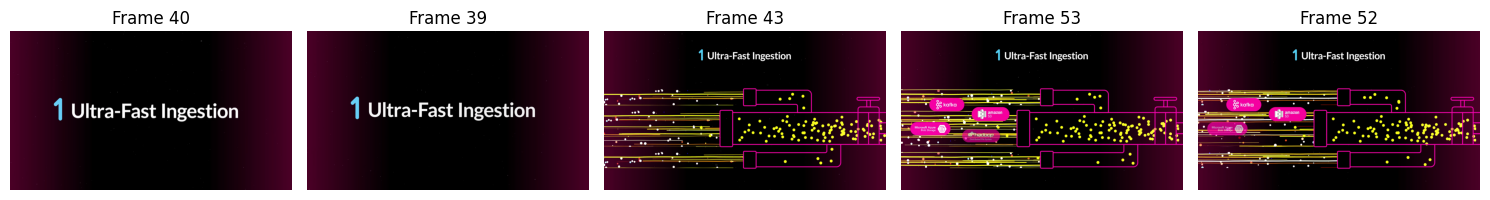

In [23]:
# Collect frame data and numbers for the top text matches
top_text_matches_indices = top_text_matches.index.tolist()
frames = [df.at[index, "frame_data"] for index in top_text_matches_indices]
frame_numbers = [df.at[index, "frame_number"] for index in top_text_matches_indices]

# Plot the frames
plot_frames(frames, frame_numbers)

___
## Example image query

### Encode image into a vector representation

**TL;DR**<br>
Summarise an image in a simpler numerical form.

**Summary**<br>
Preprocess an input image, pass it through a model to extract features, and return the resulting feature vector. This feature vector can then be used for similarity calculations.

In [24]:
def encode_image_query(image):
    # Preprocess the image and add batch dimension
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Extract features using the model
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
    
    # Convert features to NumPy array and flatten
    return image_features.cpu().numpy().flatten()

In [25]:
image_url = "https://github.com/VeryFatBoy/clip-demo/raw/main/thumbnails/1_what_makes_singlestore_unique.png"

response = requests.get(image_url)

if response.status_code == 200:
    display(Image(url = image_url))
    image_file = PILImage.open(BytesIO(response.content))

    image_query_embedding = encode_image_query(image_file)
    image_query_embedding /= np.linalg.norm(image_query_embedding)
    image_similarities = calculate_similarity(image_query_embedding, df)
    df["image_similarity"] = image_similarities
else:
    print("Failed to download the image, status code:", response.status_code)

### Find the top 5 best matches

In [26]:
top_image_matches = df.nlargest(5, "image_similarity")

print("Top 5 best matches:")
print(top_image_matches[["frame_number", "image_similarity"]].to_string(index = False))

Top 5 best matches:
 frame_number  image_similarity
            7          0.877372
            6          0.607051
            9          0.591181
            4          0.513214
           15          0.502777


### Show the frames

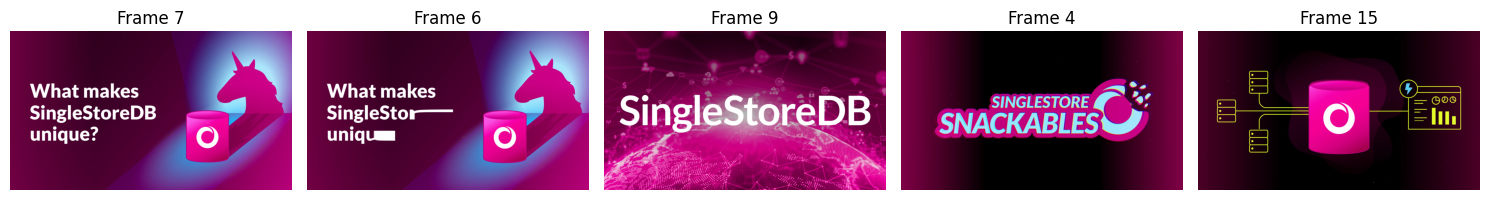

In [27]:
# Collect frame data and numbers for the top image matches
top_image_matches_indices = top_image_matches.index.tolist()
frames = [df.at[index, "frame_data"] for index in top_image_matches_indices]
frame_numbers = [df.at[index, "frame_number"] for index in top_image_matches_indices]

# Plot the frames
plot_frames(frames, frame_numbers)

___
## Example combined query

**TL;DR**<br>
When using CLIP with both text and images in a query, balance them by element-wise averaging.

**Summary**<br>
Balancing a query that includes both text and images when using CLIP involves finding an appropriate way to combine the embeddings of the textual query and the image query. A common approach is to use element-wise averaging.

Element-wise averaging means taking the average of corresponding elements in the two embeddings. This is done by adding the elements of the two embeddings together and then dividing by the number of elements. This ensures that both the textual and visual aspects of the query contribute equally to the final representation.

CLIP generates embeddings for both images and text using the ViT model. This model processes both images and text by first converting them into a common feature space through a shared set of transformer layers. The embeddings produced for images and text have the same dimensionality.

In [28]:
combined_query_embedding = (text_query_embedding + image_query_embedding) / 2
combined_similarities = calculate_similarity(combined_query_embedding, df)
df["combined_similarity"] = combined_similarities

### Find the top 5 best matches

In [29]:
top_combined_matches = df.nlargest(5, "combined_similarity")

print("Top 5 best matches:")
print(top_combined_matches[["frame_number", "combined_similarity"]].to_string(index = False))

Top 5 best matches:
 frame_number  combined_similarity
            7             0.516626
            6             0.413325
            9             0.380147
            4             0.363691
            3             0.355250


### Show the frames

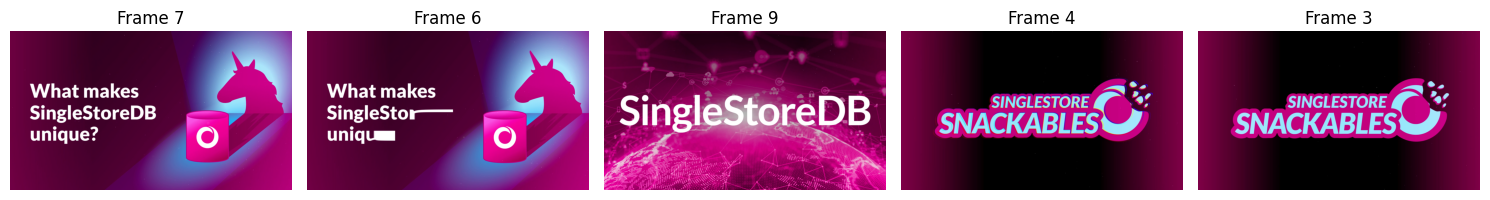

In [30]:
# Collect frame data and numbers for the top combined matches
top_combined_matches_indices = top_combined_matches.index.tolist()
frames = [df.at[index, "frame_data"] for index in top_combined_matches_indices]
frame_numbers = [df.at[index, "frame_number"] for index in top_combined_matches_indices]

# Plot the frames
plot_frames(frames, frame_numbers)

___
## Database operations

### Prepare the data for SingleStore

In [31]:
frames_df = df.copy()
frames_df.drop(
    columns = ["text_similarity", "image_similarity", "combined_similarity"],
    inplace = True
)

query_string = combined_query_embedding.copy()

### Convert the arrays to string representations

In [32]:
def process_data(arr):
    return np.array2string(arr, separator = ",").replace("\n", "")

frames_df["embedding_data"] = frames_df["embedding_data"].apply(process_data)
frames_df["frame_data"] = frames_df["frame_data"].apply(process_data)
query_string = process_data(query_string)

In [33]:
frames_df.head()

,frame_number,embedding_data,frame_data
0,1,"[-7.43980519e-04,-6.55221613e-03,-1.16424393e-...","[[[128, 0, 73], [128, 0, 73], [128, 0, 73..."
1,2,"[ 2.40150709e-02,-2.55699418e-02,-3.20772082e-...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72..."
2,3,"[-1.57121532e-02, 1.27001479e-02, 1.79456752e-...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72..."
3,4,"[-1.38396118e-02, 1.43705485e-02, 2.58065686e-...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72..."
4,5,"[-3.63449985e-03, 9.72463284e-03, 3.07160593e-...","[[[108, 0, 63], [108, 0, 63], [108, 0, 63..."


### Create the database and table

In [34]:
shared_tier_check = %sql SHOW VARIABLES LIKE "is_shared_tier"
if not shared_tier_check or shared_tier_check[0][1] == "OFF":
    %sql DROP DATABASE IF EXISTS video_db;
    %sql CREATE DATABASE IF NOT EXISTS video_db;

1 rows affected.

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [35]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [36]:
%%sql
DROP TABLE IF EXISTS frames;

CREATE TABLE IF NOT EXISTS frames (
    frame_number INT(10) UNSIGNED NOT NULL,
    embedding_data VECTOR(512) NOT NULL,
    frame_data TEXT,
    KEY(frame_number)
);

++
||
++
++

### Write the DataFrame to SingleStore

In [37]:
frames_df.to_sql(
    "frames",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

142

### Read back some data

In [38]:
%%sql
SELECT frame_number,
    SUBSTRING(embedding_data, 1, 50) AS embedding_data,
    SUBSTRING(frame_data, 1, 50) AS frame_data
FROM frames
LIMIT 1;

1 rows affected.

frame_number,embedding_data,frame_data
1,b'\xb0\x07C\xba\xf9\xb3\xd6\xbb\xee\xbf>\xbcw\xbd\xf0\xbc(Q\xda<\xd2\x86\xa5\xbc\x81\x94\xda\xbbx@\xb6=\xc3\x9f==\xcb.\xcd;\xad?\x8f:\x94I\x1f<\xf3\xb4',"[[[128, 0, 73], [128, 0, 73], [128, 0, 73],"


### Create the ANN index

In [39]:
%%sql
ALTER TABLE frames ADD VECTOR INDEX (embedding_data)
     INDEX_OPTIONS '{
          "index_type":"AUTO",
          "metric_type":"DOT_PRODUCT"
     }';

++
||
++
++

___
## Example query

In [40]:
%config SqlMagic.named_parameters = True

### Dot Product without ANN index

In [41]:
%%sql
SELECT frame_number,
    embedding_data <*> :query_string AS similarity
FROM frames
ORDER BY similarity USE INDEX () DESC
LIMIT 5;

5 rows affected.

frame_number,similarity
7,0.5166257619857788
6,0.4133252203464508
9,0.38014671206474304
4,0.36369115114212036
3,0.35524997115135193


### Dot Product with ANN index

In [42]:
%%sql
SELECT frame_number,
    embedding_data <*> :query_string AS similarity
FROM frames
ORDER BY similarity DESC
LIMIT 5;

5 rows affected.

frame_number,similarity
7,0.5166257619857788
6,0.4133252203464508
9,0.38014671206474304
4,0.36369115114212036
3,0.35524997115135193


In [43]:
sql_query = """
SELECT frame_number, embedding_data, frame_data
FROM frames
ORDER BY embedding_data <*> %s DESC
LIMIT 5;
"""

new_frames_df = pd.read_sql(
    sql_query,
    con = db_connection,
    params = (query_string,)
)

In [44]:
new_frames_df.head()

,frame_number,embedding_data,frame_data
0,7,"[0.051999576, -0.0120492205, -0.010365603, -0....","[[[108, 0, 63], [108, 0, 63], [108, 0, 63..."
1,6,"[0.008241597, -0.011805278, 0.013899713, -0.00...","[[[108, 0, 63], [108, 0, 63], [108, 0, 63..."
2,9,"[-0.0071643167, 0.06342551, -0.0034481757, 0.0...","[[[103, 0, 56], [103, 0, 56], [103, 0, 56..."
3,4,"[-0.013839612, 0.014370549, 0.025806569, 0.002...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72..."
4,3,"[-0.015712153, 0.012700148, 0.017945675, -0.00...","[[[127, 0, 72], [127, 0, 72], [127, 0, 72..."


___
## Limitations

- **Frame Extraction:** Frames are extracted at a fixed interval based on the frame rate. This could miss important frames or include redundant ones.

- **Embedding Generation:** Batch processing multiple frames at once to use parallelism should improve performance.

- **Similarity Calculation:** Similarities could be parallelized to speed up computation, especially for large videos with many frames.

___
## Cleanup

In [45]:
os.remove(local_video_path)

In [46]:
%%sql
DROP INDEX embedding_data ON frames;

++
||
++
++

In [47]:
%%sql
DROP TABLE IF EXISTS frames;

++
||
++
++

In [48]:
shared_tier_check = %sql SHOW VARIABLES LIKE "is_shared_tier"
if not shared_tier_check or shared_tier_check[0][1] == "OFF":
    %sql DROP DATABASE IF EXISTS video_db;

1 rows affected.